## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data preparation

The following data preparation steps helped us to prepare the data for analyses:

1. Creating a 'year' column in the races dataframe to allow for comparisons across years. 

2. Binning the finals positions as 'top', 'middle', and 'bottom' to determine effect of horse positions throughout a race on relative finishing position.

3. Creating a binary column for each race where 1 corresponds to a top 3 finish, 0 corresponds to a finish outside of the top 3. This allows me to compute the percentage of top 3 finishes for each jockey.

In [2]:
######---------------Creating new variables----------------#########

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# read in datasets
races = pd.read_csv('races.csv')
runs = pd.read_csv('runs.csv')


In [3]:
# convert date column to datetime format
races['date'] = pd.to_datetime(races['date'])

# create year column
races['year'] = races['date'].dt.year

In [4]:
# define bin cutoffs and labels
bins = [0, 3, 8, 20]
labels = ['Top', 'Middle', 'Bottom']

# create new 'position' column 
runs['position'] = pd.cut(runs['result'], bins=bins, labels=labels)

In [5]:
# create new binary column where 1 = top 3 finish, 0 = non top 3 finish
runs['top3'] = runs['result'].apply(lambda x: 1 if x <= 3 else 0)

## Exploratory data analysis

Q1: How does winning percentage/average finishing ranking vary by hourse country? How have these metrics changed over time?

To analyze how winning percentage and average finishing ranking vary by horse country, and their change over time, I'll first categorize race outcomes by the country of the horse. I'll calculate the winning percentage for each country by dividing the number of wins by total races participated

In [6]:
# get number of entrants in each race
race_counts = runs.groupby('race_id')['result'].max()

# compute percentile rank for each run
runs['pct_rank'] = (runs['result'] - 1)/(runs['race_id'].map(race_counts) - 1) * 100

In [7]:
# get value counts for each country and reset the index to turn it into a DataFrame
country_counts = runs['horse_country'].value_counts().reset_index()
country_counts.columns = ['horse_country', 'count']  # Rename columns appropriately

# drop countries with fewer than 50 races competed
runs_filtered = runs[runs['horse_country'].isin(country_counts[country_counts['count'] > 50]['horse_country'])]

data = pd.merge(races, runs_filtered, on='race_id', how='left')


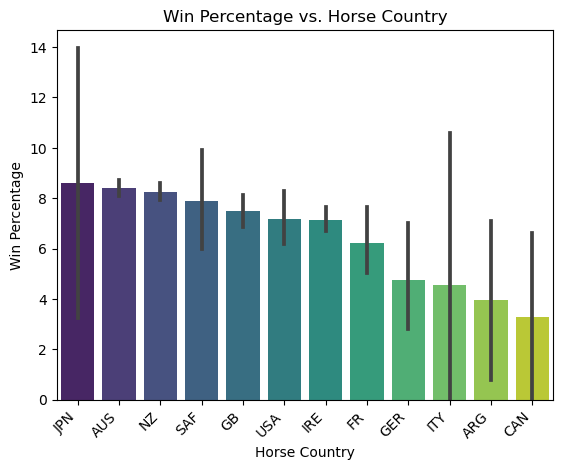

In [8]:
# multiply 'won' column by 100 to convert to percentage value
data['won'] *= 100

# plot win percentage vs. horse country
# calculate the mean win percentage for each horse country and sort the countries
order = data.groupby('horse_country')['won'].mean().sort_values(ascending=False).index

# create a bar plot using Seaborn
sns.barplot(x='horse_country', y='won', data=data, order=order, palette='viridis')

plt.xlabel('Horse Country')
plt.ylabel('Win Percentage')
plt.title('Win Percentage vs. Horse Country')

plt.xticks(rotation=45, ha='right')

plt.show()


 Japan (JPN), Australia (AUS), and New Zealand (NZ) appear to have higher win percentages, however, we see that Japan has extremely high error bars. 

For average finishing ranking, I'll average the positions where horses from each country finish. I'll plot these calculations over time and this will reveal if certain countries have historically stronger performances or if there are trends in performance improvements or declines over the years.

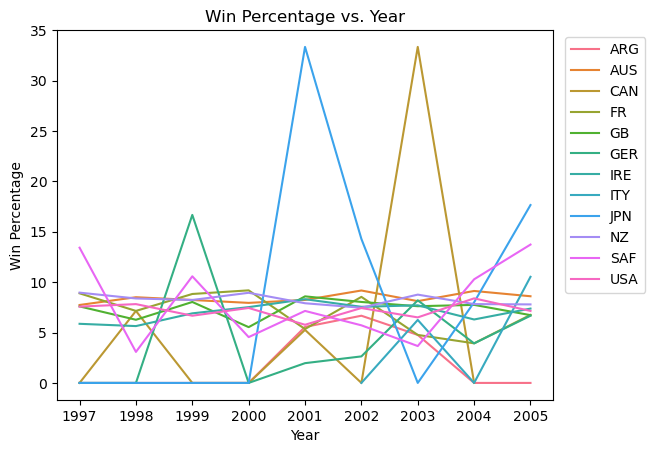

In [9]:
# get win percentage for each country for each year
won_years = data.groupby(['horse_country', 'year'])['won'].mean().reset_index()

# plot win percentage vs. year for each country
sns.lineplot(data = won_years, x = 'year', y = 'won', hue = 'horse_country')

plt.xlabel('Year')
plt.ylabel('Win Percentage')
plt.title('Win Percentage vs. Year')

plt.legend(loc = 'upper right', bbox_to_anchor = (1.2,1))

plt.show()

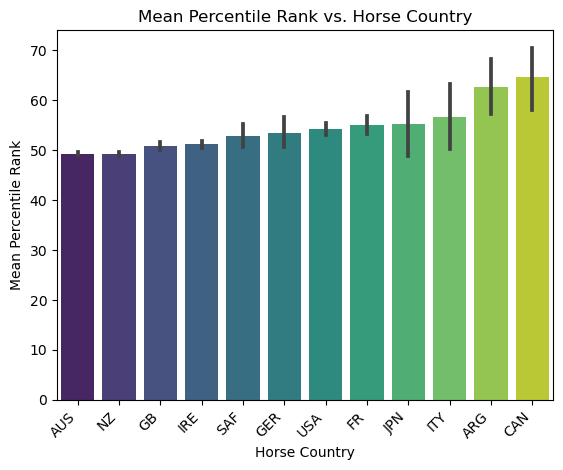

In [10]:
# Get percentile ranks for each horse country
# No need to convert to a list, since we only use it for ordering
order = data.groupby('horse_country')['pct_rank'].mean().sort_values(ascending=True).index

# Plot percentile rank vs. horse country
sns.barplot(x='horse_country', y='pct_rank', data=data, order=order, palette='viridis')

plt.xlabel('Horse Country')
plt.ylabel('Mean Percentile Rank')
plt.title('Mean Percentile Rank vs. Horse Country')

# Rotate the x-tick labels for better readability if there are many countries
plt.xticks(rotation=45, ha='right')

plt.show()


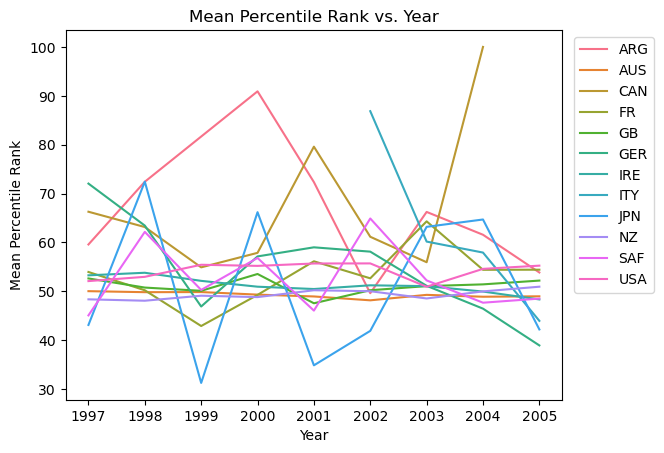

In [11]:
# get percentile rank for each country for each year
avg_places = data.groupby(['horse_country', 'year'])['pct_rank'].mean().reset_index()

# plot percentile rank vs. year for each country
sns.lineplot(data = avg_places, x = 'year', y = 'pct_rank', hue = 'horse_country')

plt.xlabel('Year')
plt.ylabel('Mean Percentile Rank')
plt.title('Mean Percentile Rank vs. Year')

plt.legend(loc = 'upper right', bbox_to_anchor = (1.2,1))

plt.show()

Countries like Australia (AUS), New Zealand (NZ), and Great Britain (GB) have lower mean percentile ranks, suggesting that on average, horses from these countries perform better than those from other countries in the dataset.

### Conclusion for Q1

Japan has the highest win percentage (8.6%), but the confidence interval is extremely wide. Australia (8.4%) and New Zealand (8.3%) are close behind with much narrower confidence intervals. New Zealand and Australia are tied with the lowest average percentile rank (49.3%), with Great Britain (50.8%) and Ireland (51.1%) close behind. To clarify, a lower mean percentile rank indicates a better averagbe performance, since it gives the mean percentage of horses in a race that finish before horses from a given country. From these results, we can say with the most confidence that Australia and New Zealand produce the most successful racehorses, with Great Britain, Ireland, and Japan as potential contenders.  

# Analysis 2
Q2: How does positioning throughout sections of the race correlate to the final outcome? Do positions stay relatively constant throughout the race?

In order to provide categorical meaning for the finishing results as opposed to the raw numbers, I create a new variable called “position” which labeled finishing results between 1st and 3rd place as “top”, 4th through 8th place as “middle” and any position after 8th place as “bottom”, since each race had a different amount of contenders. I chose these bins because in real life there is a heavily skewed emphasis on the top 3 positions and a deemphasis on any position after around 8th place because you can’t make money on these bottom horses. 

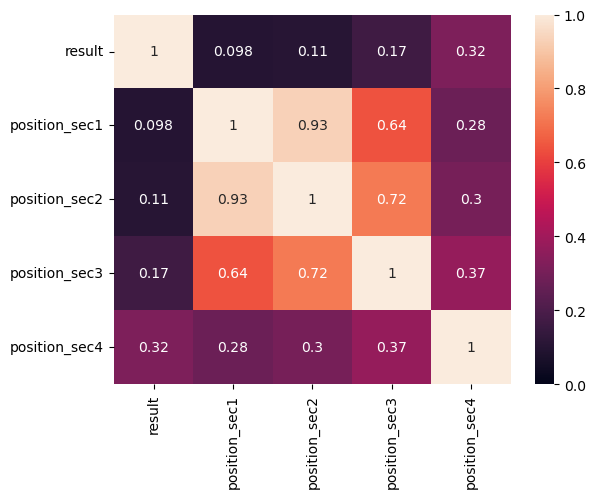

In [12]:
# 1/3 of first plot

# Filter data to only include horses that finished in "top"
top_df = runs[runs['position'] == 'Top']

top_df

# Only include relevant columns in heat map
selected_columns = ['result','position_sec1', 'position_sec2', 'position_sec3', 'position_sec4']

top = top_df[selected_columns]

sns.heatmap(top.corr(), vmin=0, annot=True)
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

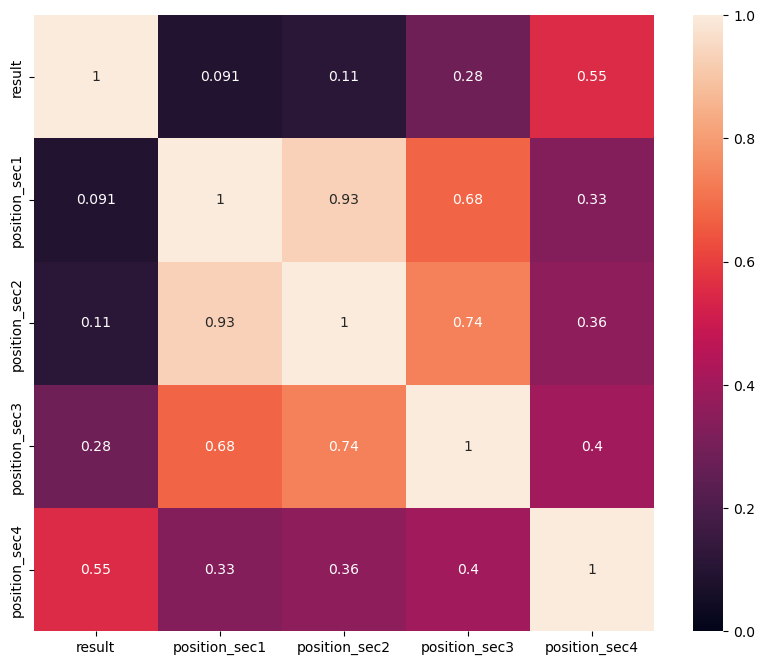

In [13]:
# 2/3 of first plot

# Repeat same as above for horses that finished in "middle"
middle_df = runs[runs['position'] == 'Middle']

middle_df

selected_columns = ['result', 'position_sec1', 'position_sec2', 'position_sec3', 'position_sec4']

middle = middle_df[selected_columns]

sns.heatmap(middle.corr(), vmin=0, annot=True)
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

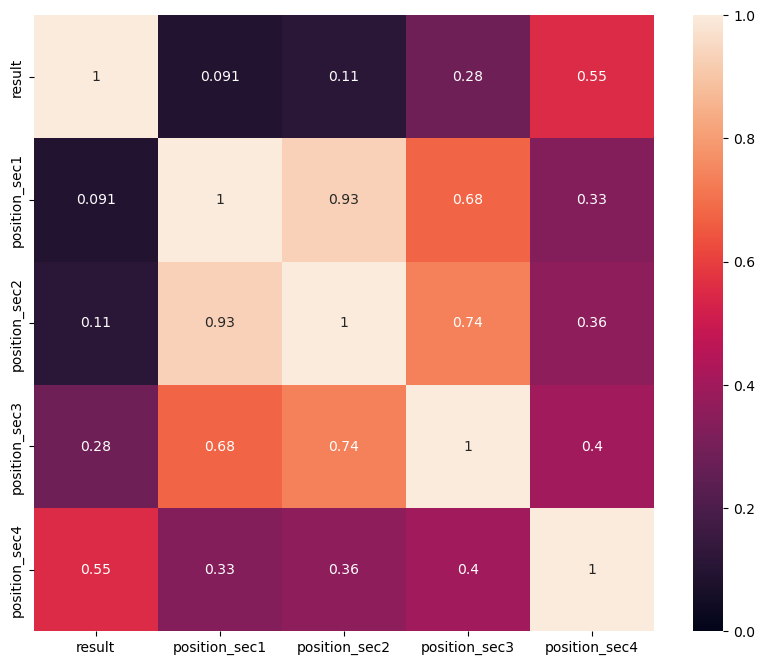

In [14]:
# 3/3 of first plot

# Repeat same as above for horses that finished in "bottom"
bottom_df = runs[runs['position'] == 'Bottom']

bottom_df

selected_columns = ['result', 'position_sec1', 'position_sec2', 'position_sec3', 'position_sec4']

bottom = middle_df[selected_columns]

sns.heatmap(bottom.corr(), vmin=0, annot=True)
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

In [24]:
# Second line plot

# Finding mean of the position at each section for horses who finished in "top"
top = runs[runs['result']<=3]

top_mean = top[['position_sec1', 'position_sec2', 'position_sec3', 'position_sec4']].mean()

top_mean


position_sec1    5.675093
position_sec2    5.441338
position_sec3    4.069544
position_sec4    2.797966
dtype: float64

In [25]:
# Finding mean of the position at each section for horses who finished in "middle"
middle = runs[(runs['result']<=8) & (runs['result']>=4)]

middle_mean = middle[['position_sec1', 'position_sec2', 'position_sec3', 'position_sec4']].mean()

middle_mean

position_sec1    6.951925
position_sec2    6.877331
position_sec3    6.532493
position_sec4    6.166970
dtype: float64

In [26]:
# Finding mean of the position at each section for horses who finished in "bottom"
bottom = runs[runs['result']>=9]

bottom_mean = bottom[['position_sec1', 'position_sec2', 'position_sec3', 'position_sec4']].mean()

bottom_mean

position_sec1     7.516770
position_sec2     7.745529
position_sec3     9.025885
position_sec4    10.399907
dtype: float64

In [27]:
# Creating a DataFrame of the mean positions
mean_positions = np.vstack([top_mean, middle_mean, bottom_mean])

df = pd.DataFrame(mean_positions)

new_indices = {'0': 'index1', '1': 'index2', '2': 'index3'}

df.index = ['top', 'middle', 'bottom']

df.columns = ['position_1', 'position_2', 'position_3', 'position_4']

df.reset_index(inplace = True)

# Made position 1-4 its own column of numeric values for x axis of plot
value_columns = ['position_1', 'position_2', 'position_3', 'position_4']

df_melted = pd.melt(df, value_vars=value_columns,
                    var_name='column', value_name='value')

df_melted['category'] = ['Finished Top 3', 'Finished Middle 4-8', 'Finished Bottom 9+'] * 4

df_melted['column'] = df_melted['column'].apply(lambda x: x.split('_')[1])

# Labeling columns in DataFrame how I want them to appear on axes/legend
df_melted.rename(columns={'column': 'Section of Track'}, inplace=True)

df_melted.rename(columns={'value': 'Average Place of Horse'}, inplace=True)

df_melted.rename(columns={'category': 'Final Result'}, inplace=True)

df_melted

,Section of Track,Average Place of Horse,Final Result
0,1,5.675093,Finished Top 3
1,1,6.951925,Finished Middle 4-8
2,1,7.516770,Finished Bottom 9+
3,2,5.441338,Finished Top 3
4,2,6.877331,Finished Middle 4-8
5,2,7.745529,Finished Bottom 9+
6,3,4.069544,Finished Top 3
7,3,6.532493,Finished Middle 4-8
8,3,9.025885,Finished Bottom 9+
9,4,2.797966,Finished Top 3


<Axes: xlabel='Section of Track', ylabel='Average Place of Horse'>

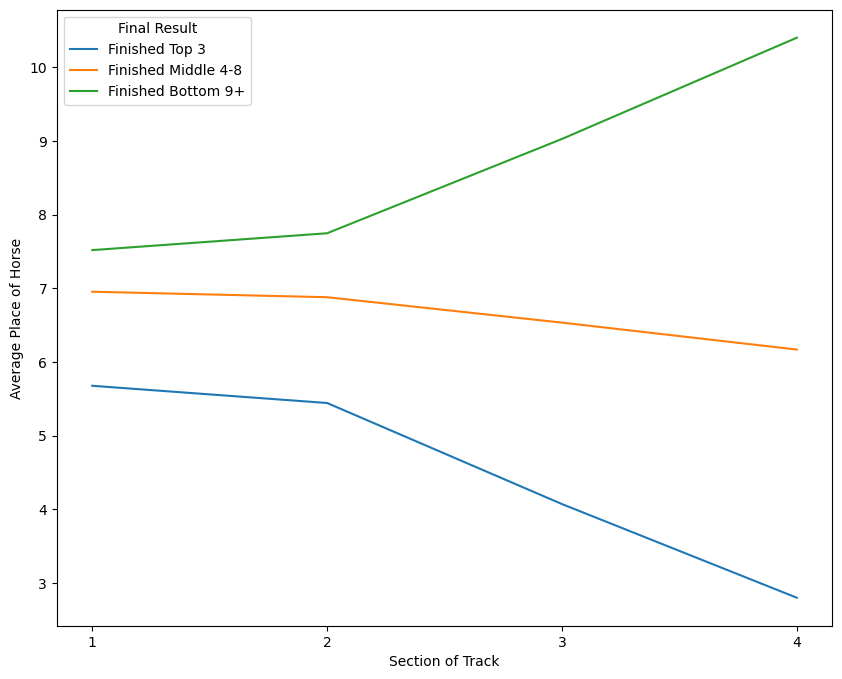

In [133]:
sns.lineplot(x='Section of Track', y='Average Place of Horse', data=df_melted, hue='Final Result')

The horses in each category are in fairly similar positions at the beginning of the race, on average, no matter their finishing result (low correlation). However around the end of the second leg (start of the third leg) is where the horses’ positions tend to split off and then steadily diverge as the race finishes. T

### Conclusion for Q2

For horses that finish in the top 3, their position in the last 2 legs of the race is less correlated to where they end up finishing (0.2-0.25). For horses that finish in the middle 4, their position in the last 2 legs of the race is more correlated to where they end up finishing (0.4-0.6). for horses that finish in the bottom 4, their position in the last 2 legs of the race is more correlated to where they end up finishing (0.4-0.6). Around end of the second leg (start of the third leg) is where the horses’ positions tend to split off and then steadily diverge as the race finishes.  
  

# Analysis 3
Q3: How accurate are the win odds to determine the outcome?

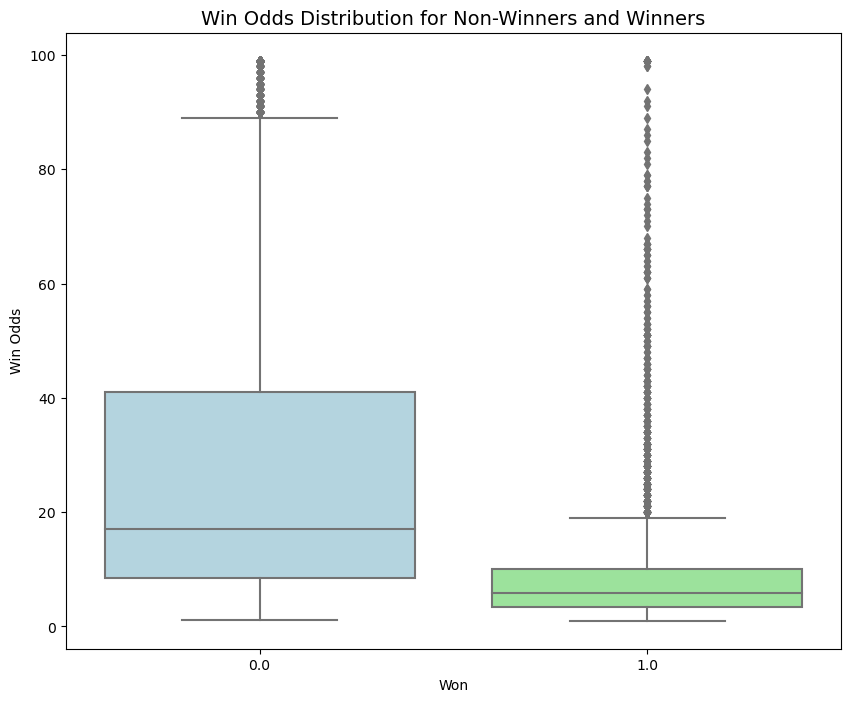

In [203]:
# Creating the boxplot for win odds distribution for winners and non-winners
# 0 = non winners, 1 = winners 
ax = sns.boxplot(x="won", y="win_odds", data=runs, palette=["lightblue", "lightgreen"])
plt.title("Win Odds Distribution for Non-Winners and Winners", fontsize=14)
plt.ylabel("Win Odds")
plt.xlabel("Won")


plt.show()

In [204]:
# calculating statistics on outliers for the boxplot
outliers = []

for i in range(2):  # Assuming two categories (winners and non-winners)
    category_data = runs[runs["won"] == i]["win_odds"]
    q1 = np.percentile(category_data, 25)
    q3 = np.percentile(category_data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    category_outliers = category_data[(category_data < lower_bound) | (category_data > upper_bound)]
    outliers.extend(category_outliers)

    # Print or use len(category_outliers) to get the count for each category
    print(f"Number of outliers for category {i}: {len(category_outliers)}")

# Finding the total percentage of winners and non winners
total_non_winners = len(runs.loc[runs['won']==0])
total_winners = len(runs.loc[runs['won']==1])

#Calculating the percentage of outliers for each boxplot 
percentage_outliers1 = (8076 / total_non_winners) * 100
print(f"Percentage of outliers for non-winners: {percentage_outliers1:.2f}%")

percentage_outliers2 = (583 / total_winners) * 100
print(f"Percentage of outliers for winners: {percentage_outliers2:.2f}%")
plt.show()

Number of outliers for category 0: 8440
Number of outliers for category 1: 619
Percentage of outliers for non-winners: 11.05%
Percentage of outliers for winners: 9.17%


In [205]:
runs_cleaned = runs[['race_id', 'won', 'horse_age', 'horse_country', 'horse_type', 'horse_rating',
       'horse_gear', 'declared_weight', 'actual_weight', 'draw', 'win_odds',
       'place_odds', 'horse_id']]
races_cleaned = races[['race_id', 'venue', 'config', 'surface', 'distance', 'going', 'race_class', 'date']]
#combining the two datasets using the race id 
combined_data = pd.merge(runs_cleaned, races_cleaned)

# dropping the missing values 
combined_data_cleaned = combined_data.dropna()
combined_data_cleaned.head()

# splitting data by winners and non-winners
subset_columns = [
    'race_id', 'won', 'win_odds',
    'horse_age', 'horse_rating', 'declared_weight', 'actual_weight', 'draw', 
    'place_odds', 'surface', 'distance', 'race_class'
]

# Create subset_data by selecting these columns from combined_data_cleaned
subset_data = combined_data_cleaned[subset_columns]


winners = combined_data_cleaned[combined_data_cleaned['won']==1]
non_winners = combined_data_cleaned[combined_data_cleaned['won']==0]

combined_data_cleaned.race_id.nunique()

6047

In [206]:
# creating a function that returns the win percentage for each win odd scenario
def calculate_win_percentage(data, column_name, n):
    # Group by 'race_id' and get the nth row in each group
    nth_min_odds = data.groupby('race_id').nth(n - 1)
    
    # Filter rows where 'won' is equal to 1 (actual wins)
    wins = nth_min_odds.loc[nth_min_odds['won'] == 1]
    
    # Calculate the win percentage
    win_percentage = (len(wins) / len(nth_min_odds)) * 100
    
    return win_percentage


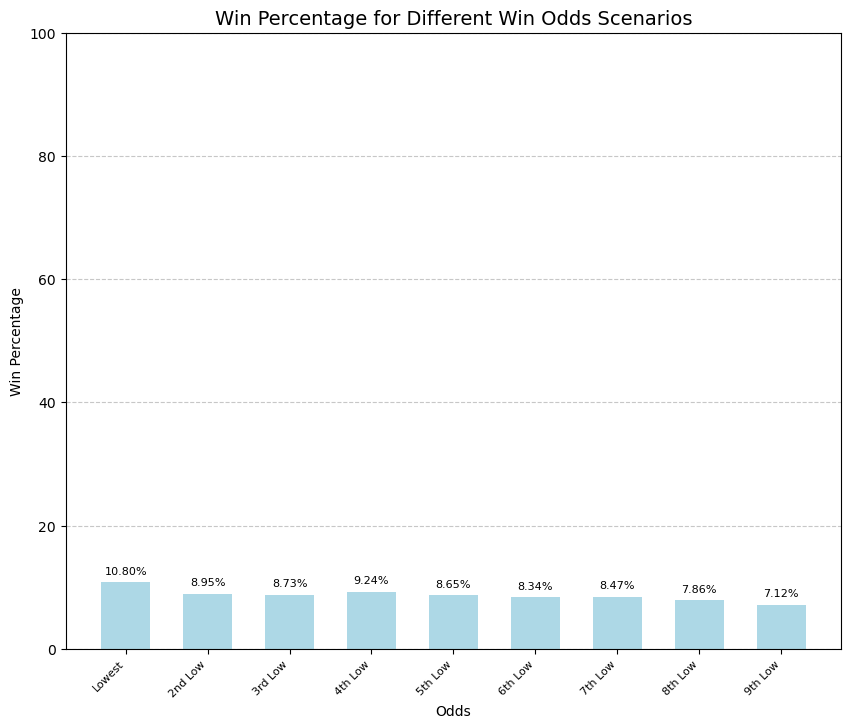

In [207]:
# Calculate win percentage for the highest win odds

highest_win_percentage = calculate_win_percentage(subset_data, 'win_odds', 1)
second_win_percentage = calculate_win_percentage(subset_data, 'win_odds', 2)
third_win_percentage = calculate_win_percentage(subset_data, 'win_odds', 3)
fourth_win_percentage = calculate_win_percentage(subset_data, 'win_odds', 4)
fifth_win_percentage = calculate_win_percentage(subset_data, 'win_odds', 5)
sixth_win_percentage = calculate_win_percentage(subset_data, 'win_odds', 6)
seventh_win_percentage = calculate_win_percentage(subset_data, 'win_odds', 7)
eigth_win_percentage = calculate_win_percentage(subset_data, 'win_odds', 8)
ninth_win_percentage = calculate_win_percentage(subset_data, 'win_odds', 9)

# Create a bar chart
labels = ['Lowest', '2nd Low', '3rd Low', '4th Low', '5th Low', '6th Low', '7th Low', '8th Low', '9th Low']
percentages = [highest_win_percentage, second_win_percentage, third_win_percentage, fourth_win_percentage, fifth_win_percentage, sixth_win_percentage, seventh_win_percentage, eigth_win_percentage, ninth_win_percentage]


plt.bar(labels, percentages, color = 'lightblue', width = 0.6)
plt.ylabel('Win Percentage')
plt.xlabel('Odds')
plt.title('Win Percentage for Different Win Odds Scenarios', fontsize = 14)
plt.ylim(0, 100)  # Set the y-axis limit to 0-100 for percentages

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=8)
for i, percentage in enumerate(percentages):
    plt.text(i, percentage + 1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)
plt.show()

### Conclusion for Q3

From the boxplot, we can see that the range of win odds for non-winners is significantly larger. Interestingly though, the median value for non-winners is not much higher than the median for winners. Taking a look at the outliers, ~11.59% of the data are outliers for non-winners, and ~9.62% for the winners. From the bar chart, we can see there is a significant decrease in actual win percentage between the horses with the best odds and the rest of the horses. Thus, the win odds set can be seen as accurate, as they do better predict which horses win. As the odds worsen, the win percentage also decreases. However, it is important to note that even the horses with the best odds only have a true win rate of about 30%. 

# Analysis 4
Q4: Which jockeys consistently perform well regardless of the odds set against them?

In [208]:
runs_data = pd.read_csv('runs.csv')

runs_data.dropna(subset=['result', 'win_odds', 'jockey_id'], inplace=True)  # Dropping rows where important columns are missing


# Define a function for the performance metric - top 3 finish
def top_3_finish(row):
    return 1 if row['result'] <= 3 else 0

# Apply the function to create a new column for top 3 finishes
runs_data['top_3_finish'] = runs_data.apply(top_3_finish, axis=1)

# Group by jockey_id to aggregate data
jockey_performance = runs_data.groupby('jockey_id').agg(
    total_races=('race_id', 'count'),
    top_3_finishes=('top_3_finish', 'sum'),
    average_odds=('win_odds', 'mean')
)

# Calculate the proportion of top 3 finishes for each jockey
jockey_performance['top_3_finish_rate'] = jockey_performance['top_3_finishes'] / jockey_performance['total_races']

# Sort jockeys first by top 3 finish rate and then by average odds (high to low)
jockey_performance_sorted = jockey_performance.sort_values(by=['top_3_finish_rate', 'average_odds'], ascending=[False, False])


# Selecting top 10 jockeys for visualization
top_10_jockeys = jockey_performance_sorted.head(10)
top_10_jockeys

,total_races,top_3_finishes,average_odds,top_3_finish_rate
jockey_id,,,,
95,1975,1020,5.955494,0.516456
167,2,1,66.000000,0.500000
54,2,1,56.000000,0.500000
182,5,2,16.340000,0.400000
80,5,2,12.840000,0.400000
153,5,2,10.620000,0.400000
2,4719,1811,9.663806,0.383768
115,1290,478,13.058992,0.370543
65,11,4,39.518182,0.363636


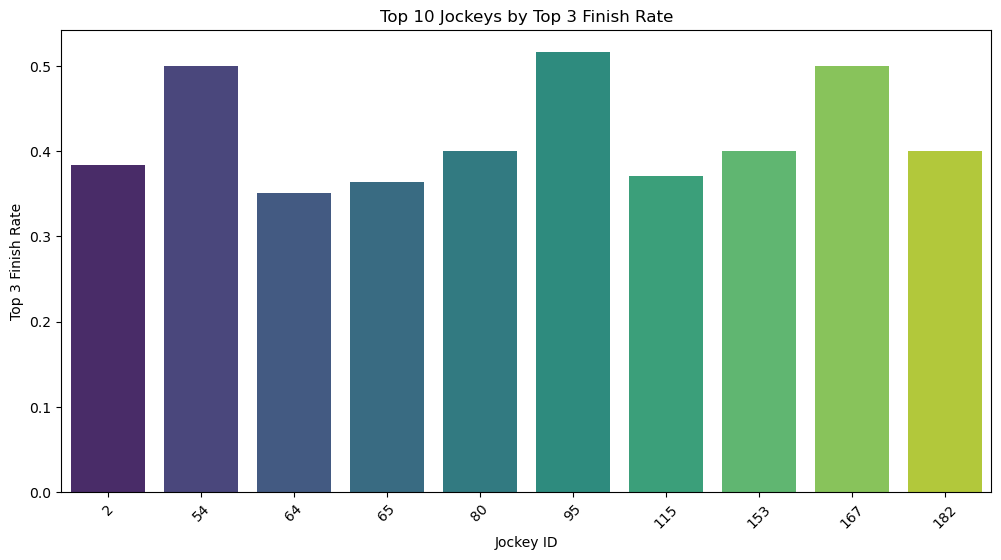

In [209]:
# First Graph: Bar plot of Top 3 Finish Rate
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_jockeys.index, y='top_3_finish_rate', data=top_10_jockeys, palette="viridis")
plt.title('Top 10 Jockeys by Top 3 Finish Rate')
plt.xlabel('Jockey ID')
plt.ylabel('Top 3 Finish Rate')
plt.xticks(rotation=45)
plt.show()


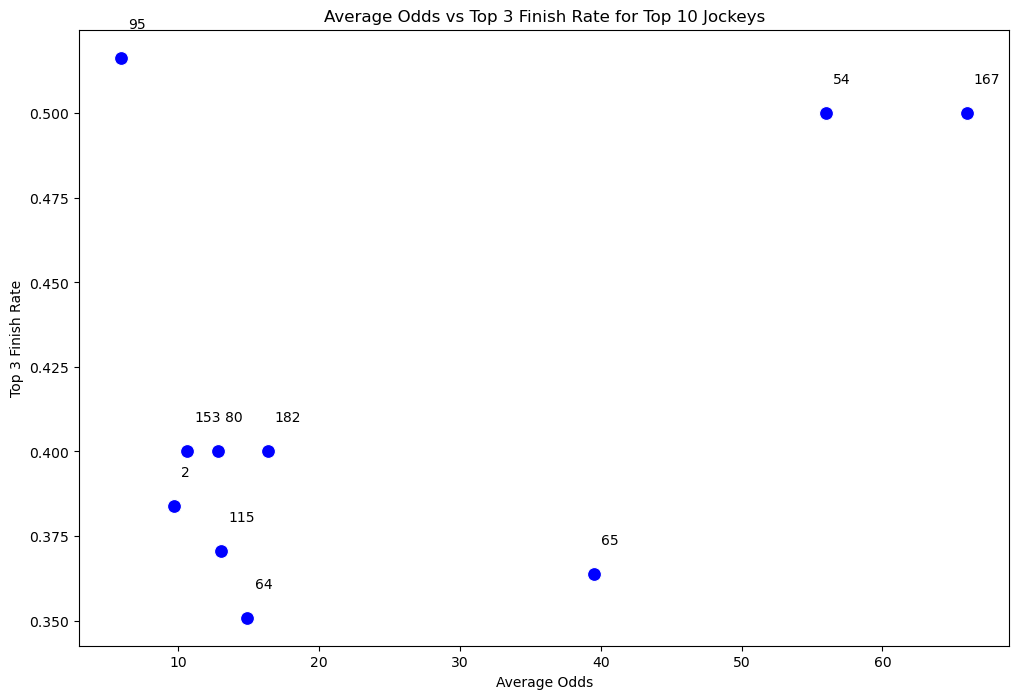

In [177]:
# Second Graph: Scatter plot of Average Odds vs Top 3 Finish Rate

# Adjusting the position of annotations to shift them up and to the right of each point

plt.figure(figsize=(12, 8))
sns.scatterplot(x='average_odds', y='top_3_finish_rate', data=top_10_jockeys, s=100, color="blue")

# Shifting annotation position up and to the right of each point
for idx, row in top_10_jockeys.iterrows():
    plt.text(row['average_odds'] + 0.5, row['top_3_finish_rate'] + 0.01, f'{idx}', color='black', ha='left', va='center')

plt.title('Average Odds vs Top 3 Finish Rate for Top 10 Jockeys')
plt.xlabel('Average Odds')
plt.ylabel('Top 3 Finish Rate')
plt.show()

### Conclusion for Q4

Jockey ID 167 and Jockey ID 54 have top 3 finish rates of 50% at very high average odds (66 and 56 respectively), which indicates exceptional performance under highly unfavorable odds; however, these Jockey’s both only have 2 races. Jockey ID 95, with a top 3 finish rate of around 51.65% and average odds of about 5.96, shows consistent high performance even at lower odds.

## Summary of Data

In [184]:
print('Average win percentage by country:')
print(data.groupby('horse_country')['won'].mean().sort_values(ascending = False), end = '\n\n\n')

print('Average finishing percentile rank by country:')
print(data.groupby('horse_country')['pct_rank'].mean().sort_values(ascending = True))

Average win percentage by country:
horse_country
JPN    860.215054
AUS    841.637130
NZ     825.908281
SAF    788.321168
GB     747.353452
USA    716.286515
IRE    715.172348
FR     620.525060
GER    476.190476
ITY    454.545455
ARG    393.700787
CAN    329.670330
Name: won, dtype: float64


Average finishing percentile rank by country:
horse_country
AUS    49.252547
NZ     49.258265
GB     50.821812
IRE    51.105136
SAF    52.805271
GER    53.439754
USA    54.203189
FR     54.908179
JPN    55.200084
ITY    56.635822
ARG    62.609315
CAN    64.546095
Name: pct_rank, dtype: float64


In [179]:
print(f'Most recent race date: {data["date"].max()}')
print(f'Oldest race date: {data["date"].min()}')

Most recent race date: 2005-08-28 00:00:00
Oldest race date: 1997-06-02 00:00:00


In [180]:
print(f'Mean positions around racetrack at sections 1-4 for top horses: {top_mean}')
print(f'Mean positions around racetrack at sections 1-4 for middle horses: {middle_mean}')
print(f'Mean positions around racetrack at sections 1-4 for bottom horses: {bottom_mean}')

Mean positions around racetrack at sections 1-4 for top horses: [5.6750930927780985, 5.441338438139193, 4.069544238737085, 2.797965915338098]
Mean positions around racetrack at sections 1-4 for middle horses: [6.951924900436184, 6.877331057588975, 6.532492572223275, 6.166970148430171]
Mean positions around racetrack at sections 1-4 for bottom horses: [7.516769883793751, 7.745529190731334, 9.025885463781226, 10.399906917214498]


In [181]:
corr_top = top["position_sec4"].corr(top["result"])
print(f'Correlation between position at start of last leg and end result for top horses: {corr_top:.2f}')

corr_mid = middle["position_sec4"].corr(middle["result"])
print(f'Correlation between position at start of last leg and end result for middle horses: {corr_mid:.2f}')

corr_bot = bottom["position_sec4"].corr(bottom["result"])
print(f'Correlation between position at start of last leg and end result for bottom horses: {corr_bot:.2f}')

Correlation between position at start of last leg and end result for top horses: 0.32
Correlation between position at start of last leg and end result for middle horses: 0.55
Correlation between position at start of last leg and end result for bottom horses: 0.53


# Key Takeaways

Based on the answer to Q1, stakeholders should generally favor (by purchasing or betting on) horses from Australia and New Zealand, as horses from these countries are most consistently the best. If looking for potential underdogs, stakeholders may seek to purchase or bet on horses from Great Britain, Ireland, or Japan; horses from these countries have proven their ability to perform very well, but do so less consistently than horses from Australia and New Zealand. 

Based on the analysis done for Q3, the safest bet for stakeholders to take is the horse with the best (lowest number value) win odds. The dropoff for win percentage for the second best odds is steep, from ~30% win odds for the best, to ~17% win odds for the second best. However, it is also important to consider that none of the win percentages are particularly high, since even the horses with the best odds only win ~30% of the time. Thus, using further analysis on specific race conditions, horse types, and other factors that could influence winning should be conducted to obtain the most profitable betting results. 

Stakeholders should be aware that the dataset used is for a limited subset of horse races in Hong Kong, between the years of 1997 and 2005. Since the most recent race date is almost 2 decades ago, it is possible that the climate of horse racing has changed since our analysis. Additionally, since the dataset only provides data for horse races in Hong Kong, it is possible that an analysis of races conducted in other countries may yield different trends/insights. To be most sure of the applicability of results, we recommend that stakeholders replicate our analysis on a more recent, geographically-diverse dataset of horse racing data.